# ベイズハッキング

* 黒木玄
* 2021-12-04
* [nbviewer](https://nbviewer.org/github/genkuroki/public/blob/main/0025/Bayes%20hacking.ipynb)

関連ノートブック

* [止め方で結果が変わる？](https://nbviewer.org/github/genkuroki/public/blob/main/0025/%E6%AD%A2%E3%82%81%E6%96%B9%E3%81%A7%E7%B5%90%E6%9E%9C%E3%81%8C%E5%A4%89%E3%82%8F%E3%82%8B%EF%BC%9F.ipynb)
* [Clopper-Pearsonの信頼区間](https://nbviewer.org/github/genkuroki/public/blob/main/0025/Clopper-Pearson%20confidence%20interval.ipynb)

In [1]:
using Distributions
using StatsPlots
using StatsFuns: logit, logistic
using Roots
using StatsBase: ecdf
using Memoization
using SpecialFunctions

using Base64
showimg(mime, fn; tag="img") = open(fn) do f
    base64 = base64encode(f)
    display("text/html", """<$tag src="data:$mime;base64,$base64" />""")
end

safemul(x, y) = iszero(x) ? x : x*y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)


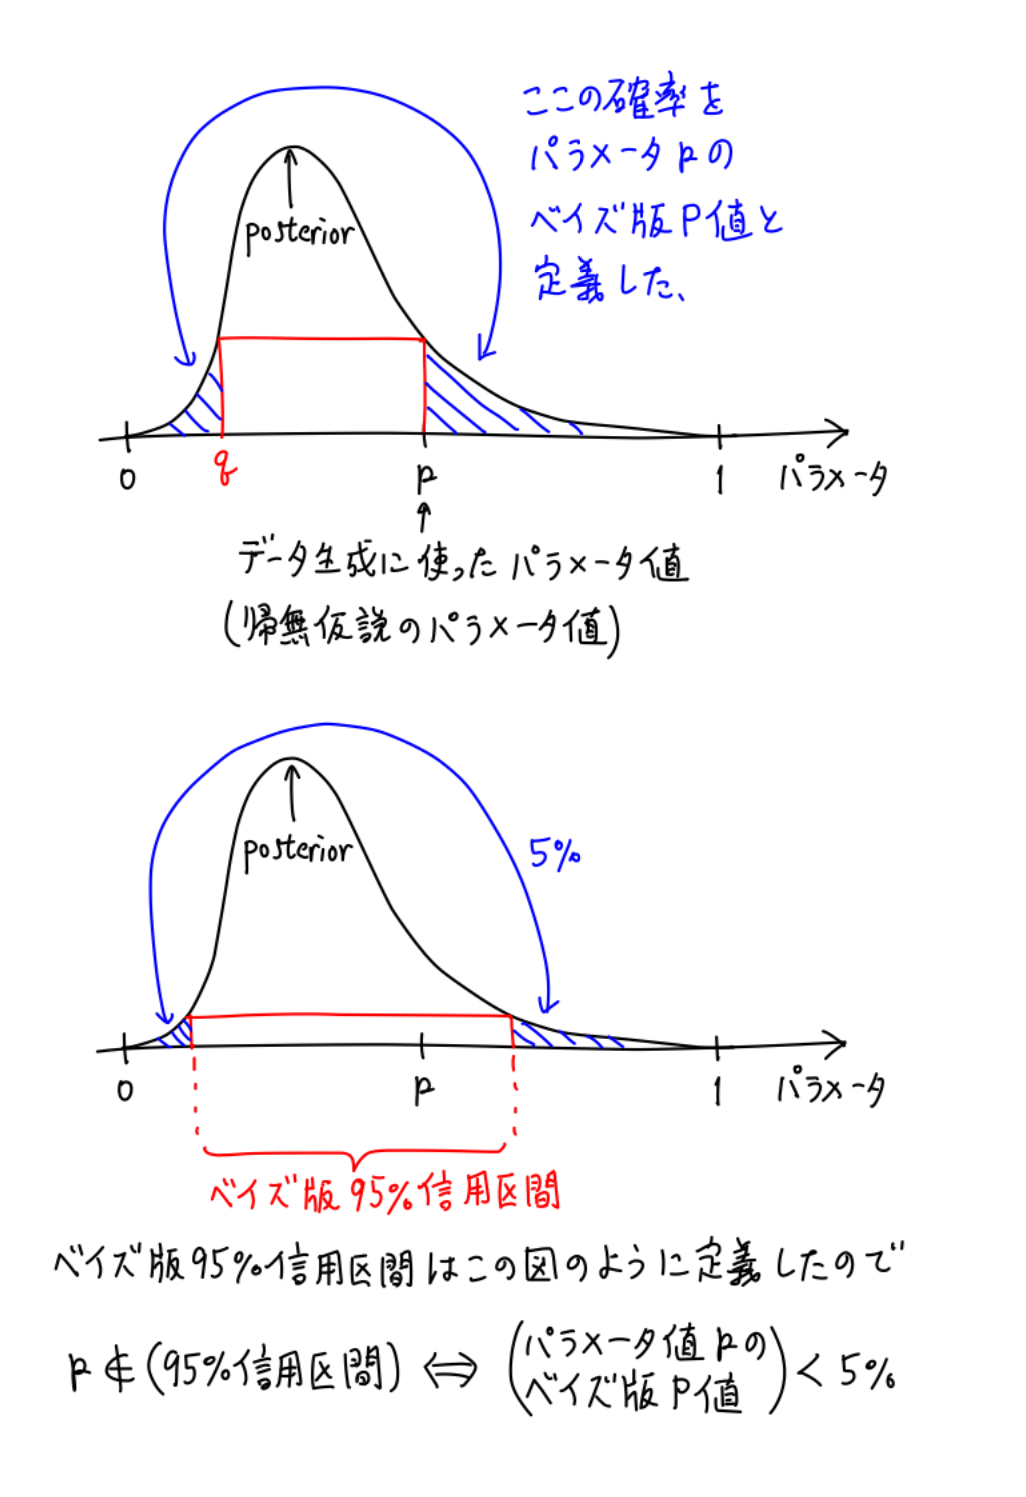

In [2]:
showimg("image/jpeg", "IMG_2864.jpg"; tag="img width=50%")


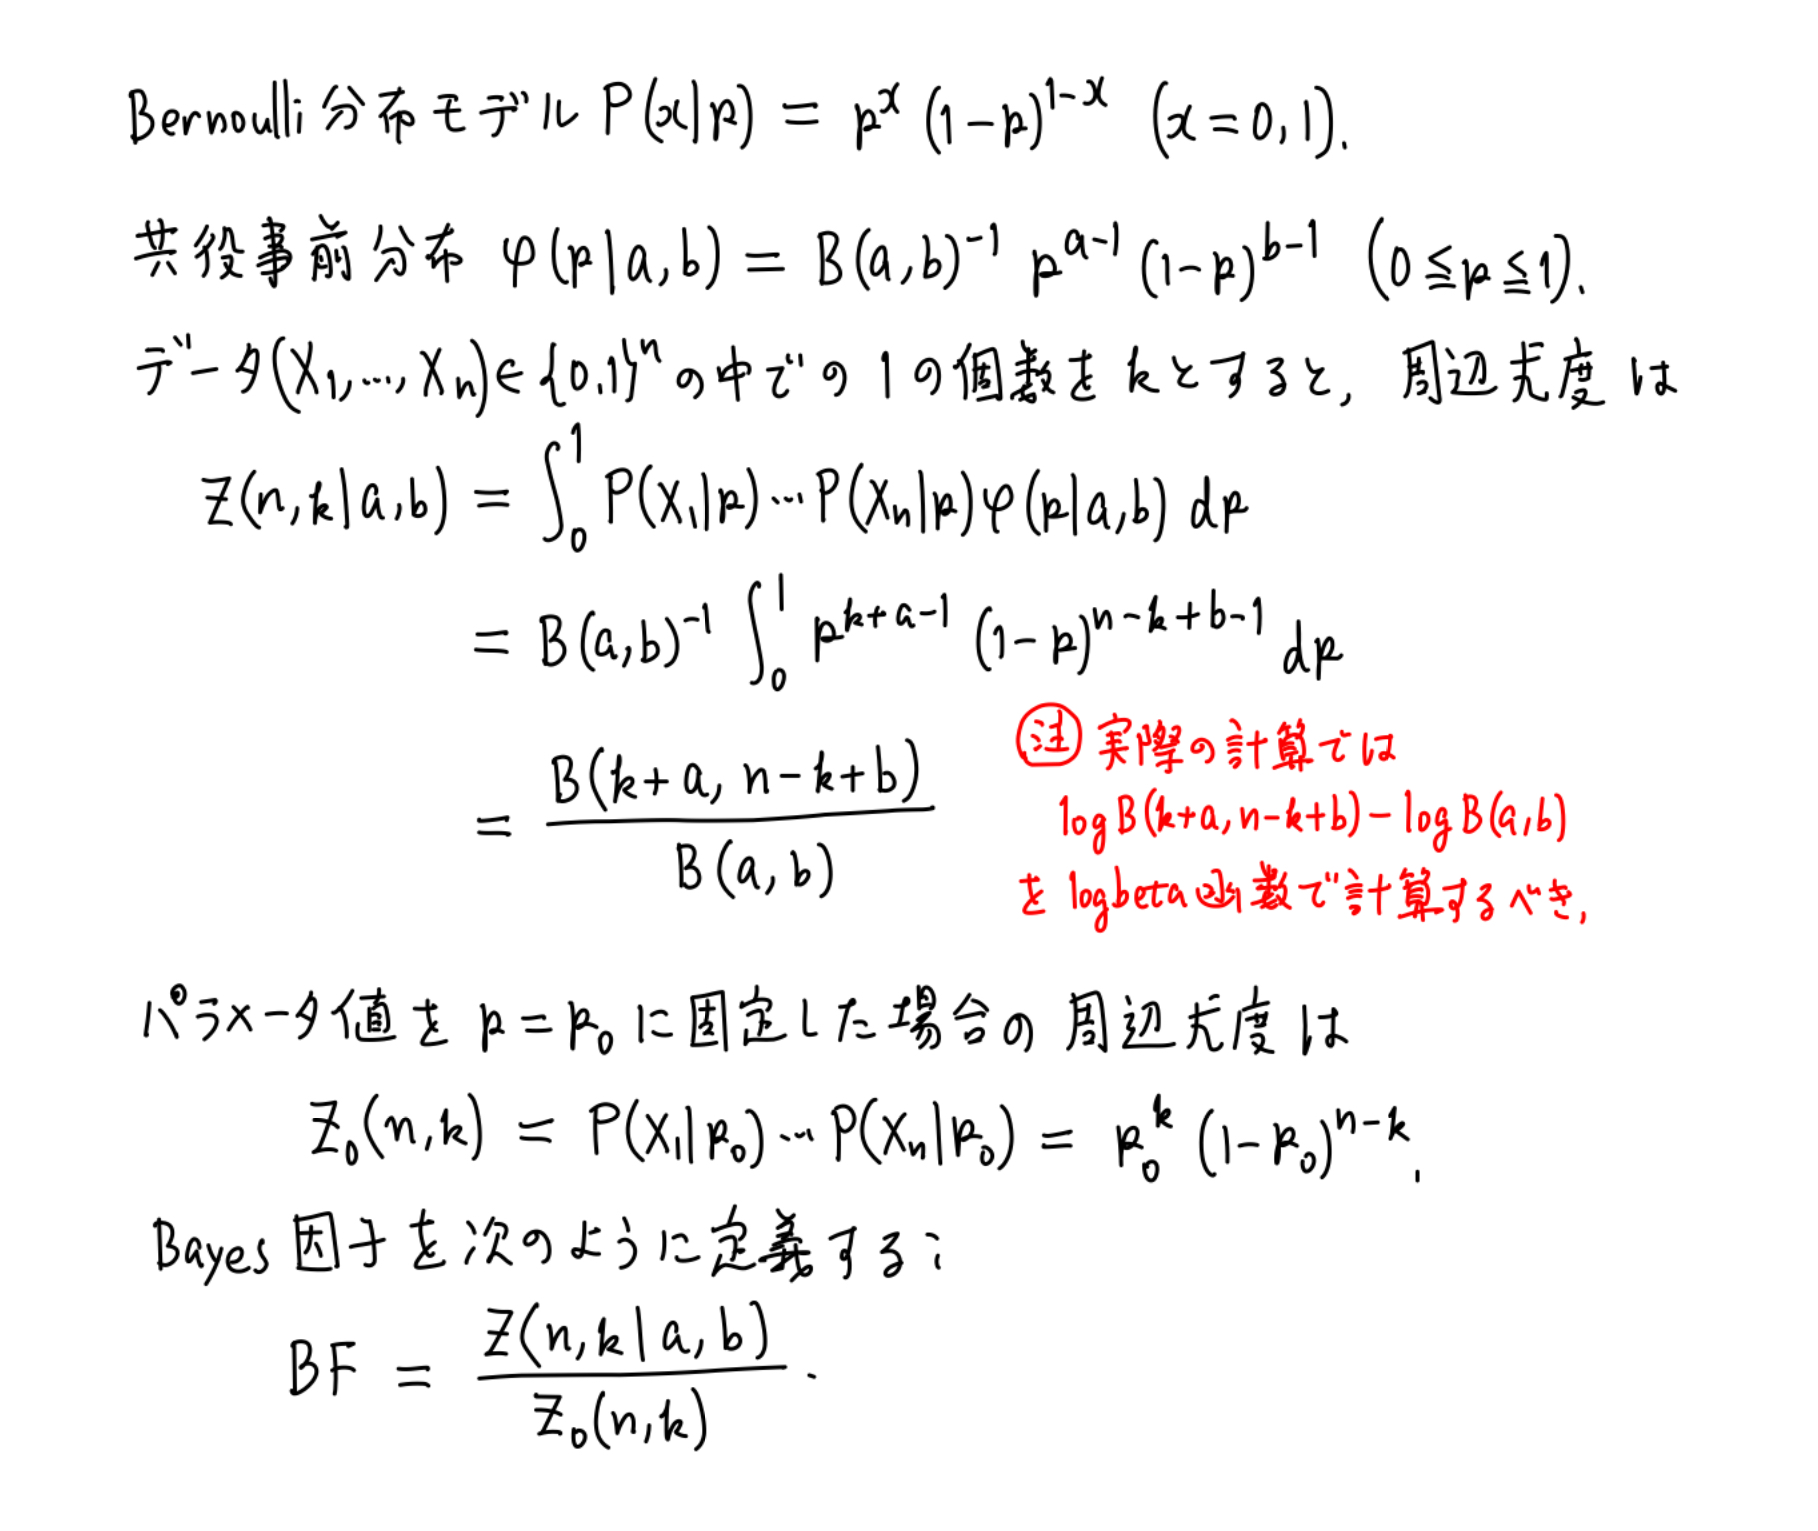

In [3]:
showimg("image/jpeg", "IMG_2865.jpg"; tag="img width=60%")

In [4]:
"""
事前分布 Beta(a, b) のもとでn回中ｋ回成功の場合の事後分布は Beta(k+a, n-k+b) になる。
デフォルトでは a = b = 1 の一様事前分布を採用することにする。
"""
posterior_dist(n, k; a=1, b=a) = Beta(k + a, n - k + b)

"""pvalue_bayes(n, p, k; a, b) < α ⇔ p ∉ (ベイズ版100(1-α)%信用区間)"""
@memoize function pvalue_bayes(n, p, k; a = 1, b = a)
    posterior = posterior_dist(n, k; a, b)
    v0 = logpdf(posterior, p)
    f(t) = logpdf(posterior, logistic(t)) - v0
    m = params(posterior) |> ((α, β),) -> (α - 1)/(α + β - 2)
    if m ≤ 0
        s = ccdf(posterior, p)
    elseif m ≥ 1
        s = cdf(posterior, p)
    elseif p ≤ m
        q = logistic(find_zero(f, min(50, logit(m) + 1)))
        s = cdf(posterior, p) + ccdf(posterior, q)
    else
        q = logistic(find_zero(f, max(-50, logit(m) - 1)))
        s = cdf(posterior, q) + ccdf(posterior, p)
    end
    min(1, s)
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
pがベイズ版信用区間から外れるまでの試行回数をL個計算
"""
function bayeshacking(N, p; α = 0.05, L = 10^4, a = 1, b = a)
    numtrials = fill(N + 1, L) # N＋１で埋め尽くされた長さLのベクトル
    Threads.@threads for i in 1:L # 並列のでL回のシミュレーションを実行
        k = 0
        for n in 1:N # ベルヌイ試行回数nの最大値はN
            k += rand(Bernoulli(p)) # kに1または0を足す。1を足す確率はp.
            if pvalue_bayes(n, p, k; a, b) < α # もしもpの値がベイズ信用区間を外れたら
                numtrials[i] = n  # n回で目的を達成したことを記録に残す
                break
            end
        end
    end
    numtrials
end

bayeshacking

In [5]:
numtrials_bhack = bayeshacking(10^3, 0.5)
[(n, ecdf(numtrials_bhack)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.2213)
 (100, 0.4054)
 (1000, 0.5572)

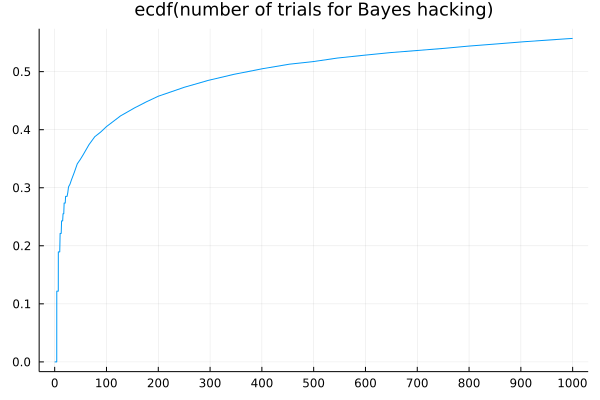

In [6]:
plot(n -> ecdf(numtrials_bhack)(n), 0, 10^3; label="", xtick=0:100:1000)
title!("ecdf(number of trials for Bayes hacking)"; titlefontsize=12)

In [7]:
"""通常のP値函数(exact版)"""
@memoize function pvalue_exact(n, p, k)
    bin = Binomial(n, p)
    p0 = pdf(bin, k)
    s = sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ p0)
    min(1, s)
end

"""通常のP値函数(正規分布近似)"""
@memoize function pvalue_normal(n, p, k)
    bin = Binomial(n, p)
    normal = Normal(mean(bin), std(bin))
    min(1, 2cdf(normal, k), 2ccdf(normal, k))
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
P値がα未満になるまでの試行回数をL個計算
"""
function phacking(pvalue_func, N, p; α = 0.05, L = 10^4)
    numtrials = fill(N + 1, L) # N＋１で埋め尽くされた長さLのベクトル
    Threads.@threads for i in 1:L # 並列のでL回のシミュレーションを実行
        k = 0
        for n in 1:N # ベルヌイ試行回数nの最大値はN
            k += rand(Bernoulli(p)) # kに1または0を足す。1を足す確率はp.
            if pvalue_func(n, p, k) < α # もしもpのP値が有意水準を下回ったら
                numtrials[i] = n # n回で目的を達成したことを記録に残す
                break
            end
        end
    end
    numtrials
end

phacking

In [8]:
numtrials_phack_exact = phacking(pvalue_exact, 10^3, 0.5)
[(n, ecdf(numtrials_phack_exact)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.0582)
 (100, 0.2293)
 (1000, 0.4104)

In [9]:
numtrials_phack_normal = phacking(pvalue_normal, 10^3, 0.5)
[(n, ecdf(numtrials_phack_normal)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.1541)
 (100, 0.3602)
 (1000, 0.5212)

In [10]:
"""ベイズ信頼区間ハックをプロット"""
function plot_bhack(; N=10^3, p=0.5, α = 0.05, L = 10^4, a = 1, b = a, kwargs...)
    numtrials_bhack = bayeshacking(N, p; α, L, a, b)
    numtrials_phack_exact = phacking(pvalue_exact, N, p; α, L)
    numtrials_phack_normal = phacking(pvalue_normal, N, p; α, L)
    
    P = plot(; legend=:bottomright)
    plot!(n -> ecdf(numtrials_bhack)(n), 0, N; label="Bayes hacking")
    plot!(n -> ecdf(numtrials_phack_exact)(n), 0, N; label="p-hacking (exact p-value)", ls=:dash)
    plot!(n -> ecdf(numtrials_phack_normal)(n), 0,N; label="p-hacking (normal dist. approx.)", ls=:dashdot)
    title!("ecdf(number of trials),  α = $α"; titlefontsize=12)
    plot!(; xlabel="n", ylabel="P(number of trials when stopped ≤ n)", guidefontsize=10)
    plot!(; kwargs...)

    Q = plot(Beta(a, b); ylim=(0, maximum(x -> pdf(Beta(a, b), x), 0.001:0.001:0.999) + 1), label="")
    plot!(; xtick=0:0.1:1, xlabel="parameter", ylabel="probability density")
    title!("prior = Beta($a, $b)"; titlefontsize=12)

    plot(P, Q; size=(640, 800), layout=(2, 1), leftmargin=2Plots.mm)
end

plot_bhack

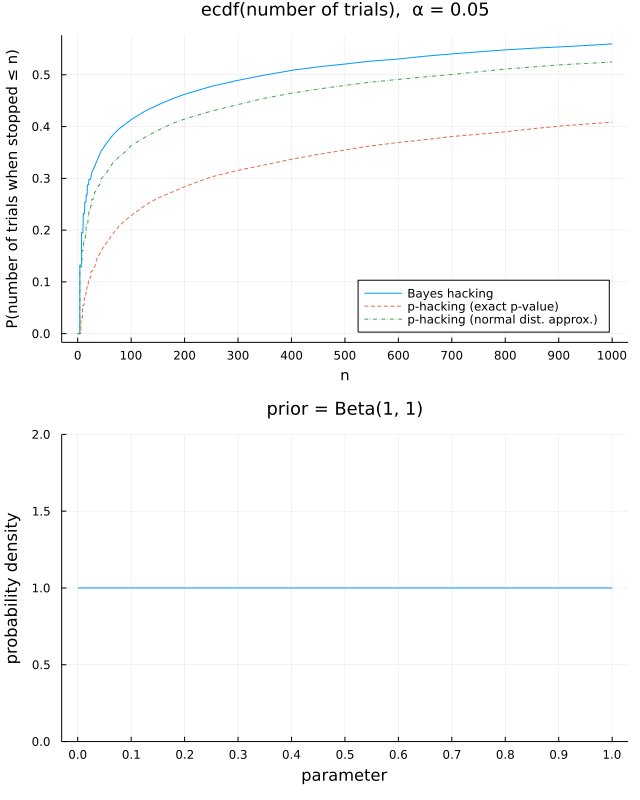

In [11]:
plot_bhack(; N=10^3, p=0.5, α = 0.05, a = 1, b = 1, xtick=0:100:1000)

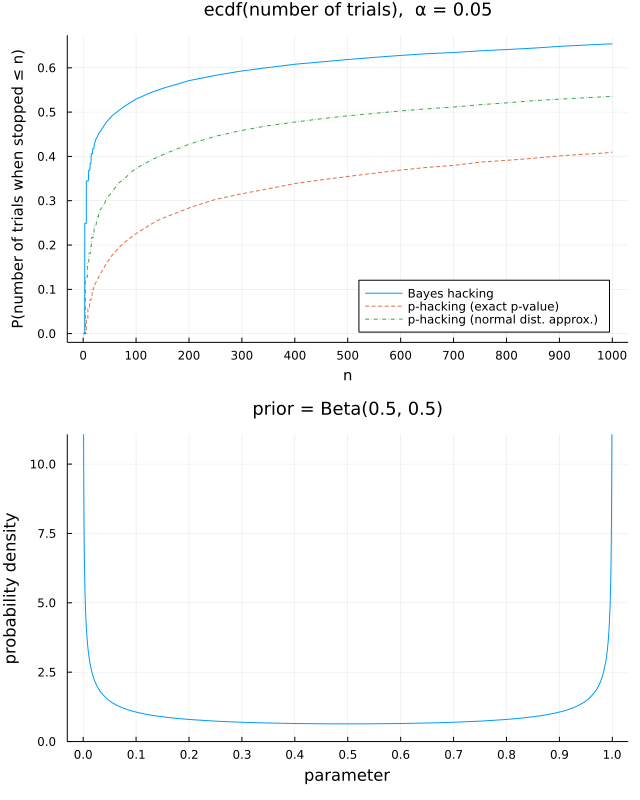

In [12]:
plot_bhack(; N=10^3, p=0.5, α = 0.05, a = 0.5, b = 0.5, xtick=0:100:1000)

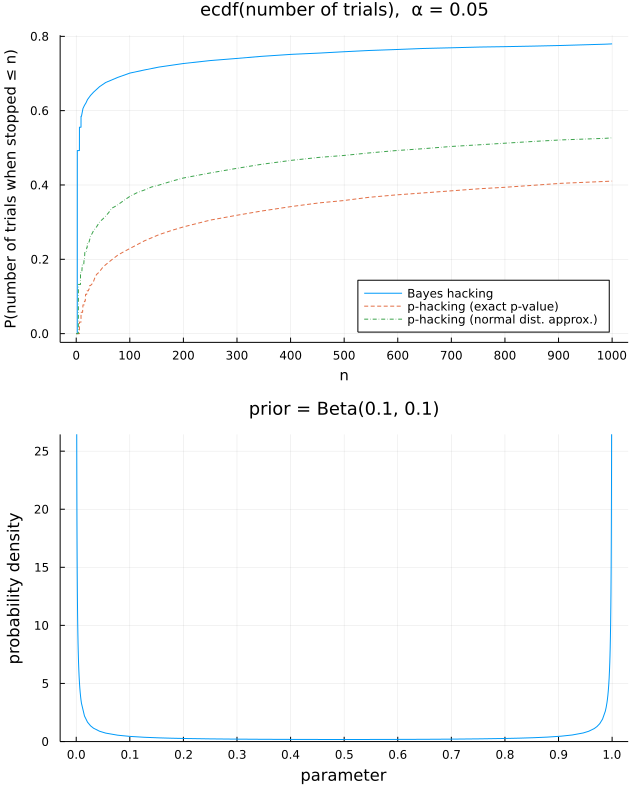

In [13]:
plot_bhack(; N=10^3, p=0.5, α = 0.05, a = 0.1, b = 0.1, xtick=0:100:1000)

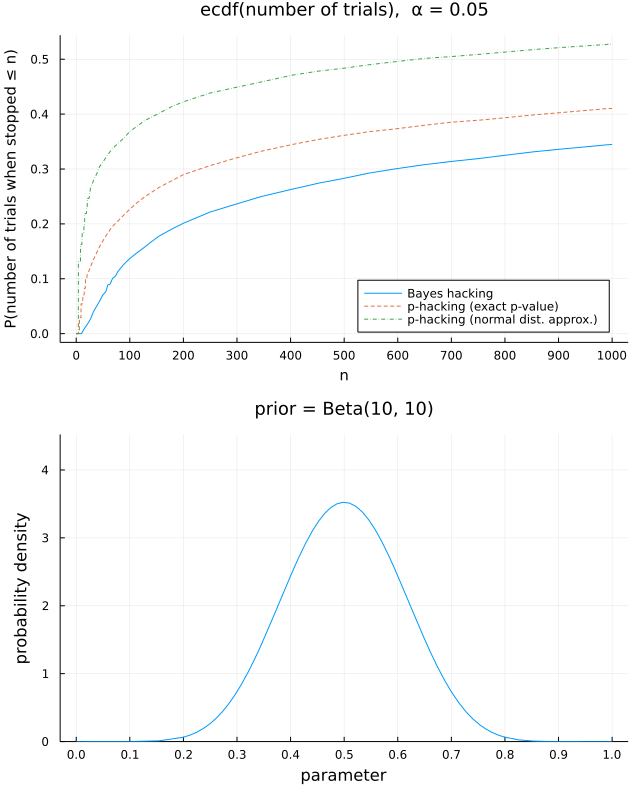

In [14]:
plot_bhack(; N=10^3, p=0.5, α = 0.05, a = 10, b = 10, xtick=0:100:1000)

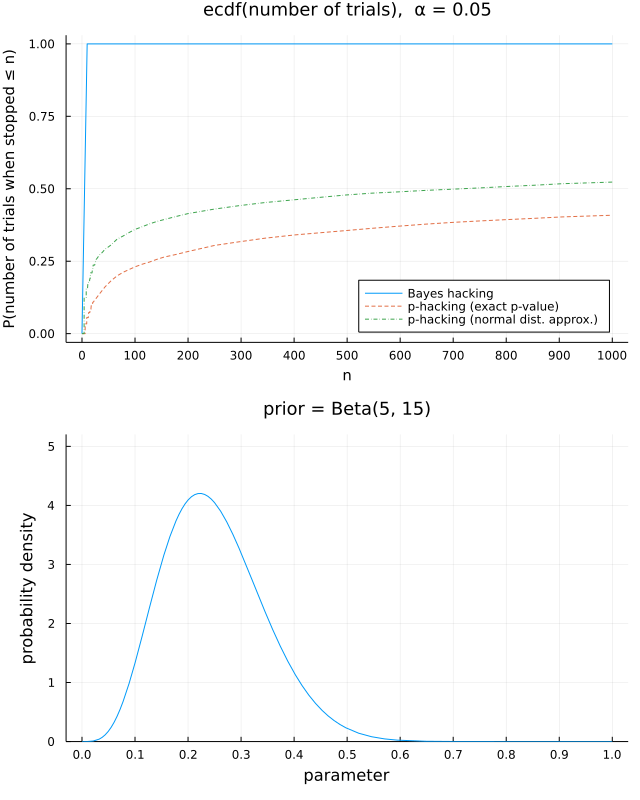

In [15]:
plot_bhack(; N=10^3, p=0.5, α = 0.05, a = 5, b = 15, xtick=0:100:1000)

Stirlingの公式を使った計算によって, $k = np$ のとき, $n\to\infty$ で

$$
\begin{aligned}
\text{log(marginal likelihood ratio)} &=
\log B(k+a, n-k+b) - \log B(a, b)) - \log(p^k(1-p)^{n-p}
\\ &=
a\log p + b\log(1-p) - \frac{1}{2}\log\frac{np(1-p)}{2\pi} - \log B(a, b) + o(1)
\end{aligned}
$$

右辺は対数周辺尤度比の漸近挙動であり, $-(1/2)\log n + \mathrm{const.}$ の形をしている. 実際にはχ²分布のスケールに合わせるために２倍してあったことに注意せよ. そのおかげで, `k` が `Binomial(n, p)` 分布に従う確率変数のとき `logmarginallikrat(n, p, k; a, b)` はその最小値(上の２倍)と自由度１のχ²分布に従う確率変数の和に近似的に等しい.

In [16]:
"""
対数周辺尤度比 (χ²分布のスケールに合わせるために2倍しておく)
Bayes因子 = exp(logmarginallikrat(n, p, k; a, b)/2)
"""
@memoize function logmarginallikrat(n, p, k; a=1, b=a)
    logmarginallik = 2(logbeta(k + a, n - k + b) - logbeta(a, b))
    logmarginallik0 = 2(safemul(k, log(p)) + safemul(n - k, log(1 - p)))
    logmarginallik - logmarginallik0
end

"""`logmarginallikrat(n, p, k; a, b)` の最小値の定数項"""
lmlr_min_const(n, p; a=1, b=a) = 2(a*log(p) + b*log(1-p) - 1/2*log(p*(1-p)/(2π)) - logbeta(a, b))

"""`logmarginallikrat(n, p, k; a, b)` の最小値の対数項＋定数項"""
lmlr_min_approx(n, p; a=1, b=a) = -log(n) + lmlr_min_const(n, p; a, b)

"""`logmarginallikrat(n, p, k; a, b)` の分布のプロット"""
function plot_ecdflmlr(n, p=0.5; L=10^4, a=1, b=a)
    k = rand(Binomial(n, p), L)
    lmlr = @. logmarginallikrat(n, p, k; a, b)
    @show lmlr_min = logmarginallikrat.(n, p, n*p; a, b)
    @show lmlr_min_approx(n, p; a, b)
    @show -log(n)
    @show lmlr_min_const(n, p; a, b)
    lmlrmmin = lmlr .- lmlr_min
    plot(; legend=:bottomright)
    plot!(x -> ecdf(lmlrmmin)(x), 0, 8; label="ecdf(log marginal likelihood ratios - min)")
    plot!(x -> cdf(Chisq(1), x); label="cdf(Chisq(1), x)")
    title!("n = $n,  p = $p,  prior = Beta($a, $b)"; titlefontsize=12)
end

plot_ecdflmlr

lmlr_min = logmarginallikrat.(n, p, n * p; a, b) = -1.9917051094206837
lmlr_min_approx(n, p; a, b) = -1.851002387704591
-(log(n)) = -2.302585092994046
lmlr_min_const(n, p; a, b) = 0.451582705289455


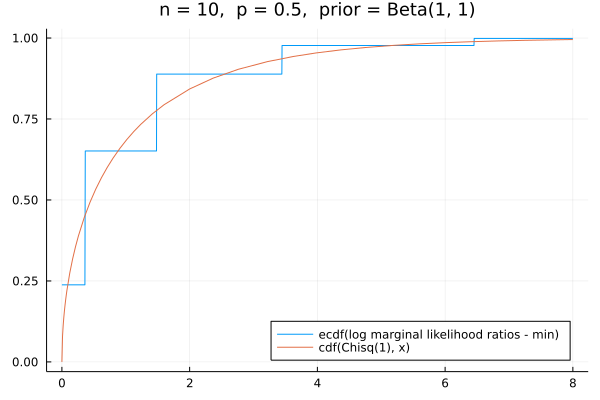

In [17]:
plot_ecdflmlr(10)

lmlr_min = logmarginallikrat.(n, p, n * p; a, b) = -4.168488225728282
lmlr_min_approx(n, p; a, b) = -4.153587480698636
-(log(n)) = -4.605170185988092
lmlr_min_const(n, p; a, b) = 0.451582705289455


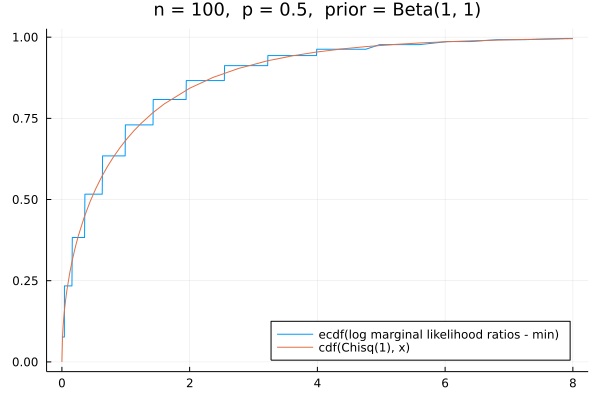

In [18]:
plot_ecdflmlr(100)

lmlr_min = logmarginallikrat.(n, p, n * p; a, b) = -6.457671574441747
lmlr_min_approx(n, p; a, b) = -6.456172573692681
-(log(n)) = -6.907755278982137
lmlr_min_const(n, p; a, b) = 0.451582705289455


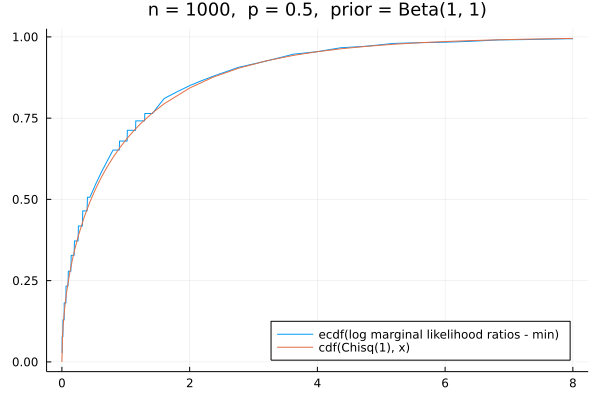

In [19]:
plot_ecdflmlr(1000)

In [20]:
"""
Bayes因子ハッキングに挑戦
Bayes因子 > threshold となるまでデータを取得し続ける。
"""
function try_bfhacking(N, p; threshold=10, L=10^4, a=1, b=a)
    numtrials = fill(N + 1, L) # N＋１で埋め尽くされた長さLのベクトル
    Threads.@threads for i in 1:L # 並列のでL回のシミュレーションを実行
        k = 0
        for n in 1:N # ベルヌイ試行回数nの最大値はN
            k += rand(Bernoulli(p)) # kに1または0を足す。1を足す確率はp.
            if logmarginallikrat(n, p, k; a, b) > 2log(threshold) # もしもベイズ因子が閾値を超えたら
                numtrials[i] = n # n回で目的を達成したこ"""logmarginallikrat(n, p, k; a, b)の最小値の定数項
                break
            end
        end
    end
    numtrials
end

"""Bayes因子ハッキングに類似のpハッキングに挑戦"""
function try_phacking_like_bfhacking(pvalue_func, N, p; threshold=10, L=10^4, a=1, b=a)
    numtrials = fill(N + 1, L) # N＋１で埋め尽くされた長さLのベクトル
    Threads.@threads for i in 1:L # 並列のでL回のシミュレーションを実行
        k = 0
        for n in 1:N # ベルヌイ試行回数nの最大値はN
            k += rand(Bernoulli(p)) # kに1または0を足す。1を足す確率はp.
            chisqthreshold_n = 2log(threshold) + log(n)
            α_n = ccdf(Chisq(1), chisqthreshold_n) # nごとに有意水準を設定する
            if pvalue_func(n, p, k) < α_n # もしもpのP値が有意水準を下回ったら
                numtrials[i] = n # n回で目的を達成したことを記録に残す
                break
            end
        end
    end
    numtrials
end

"""ベイズ因子ハッキングへの挑戦の様子をプロット"""
function plot_bfhacking(; N=5000, p=0.5, threshold=10, L=10^4, a=1, b=a)
    numtrials_bfhack = try_bfhacking(N, 0.5; threshold, L, a, b)
    numtrials_phack_like_bfhack_exact = try_phacking_like_bfhacking(pvalue_exact, N, 0.5; threshold, L, a, b)
    numtrials_phack_like_bfhack_normal = try_phacking_like_bfhacking(pvalue_normal, N, 0.5; threshold, L, a, b)

    P = plot(; legend=:bottomright)
    plot!(n -> ecdf(numtrials_bfhack)(n), 0, N; label="Bayes factor hacking")
    plot!(n -> ecdf(numtrials_phack_like_bfhack_exact)(n), 0, N; label="p-hacking like the above (exact)", ls=:dash)
    plot!(n -> ecdf(numtrials_phack_like_bfhack_normal)(n), 0, N; label="p-hacking like the above (normal dist. approx.)", ls=:dashdot)
    title!("ecdf(number of trials),  threshold = $threshold"; titlefontsize=12)
    plot!(; xlabel="n", ylabel="P(number of trials when stopped ≤ n)", guidefontsize=10)

    Q = plot(Beta(a, b); ylim=(0, maximum(x -> pdf(Beta(a, b), x), 0.001:0.001:0.999) + 1), label="")
    plot!(; xtick=0:0.1:1, xlabel="parameter", ylabel="probability density")
    title!("prior = Beta($a, $b)"; titlefontsize=12)

    plot(P, Q; size=(640, 800), layout=(2, 1), leftmargin=2Plots.mm)
end

plot_bfhacking

threshold = 10 のとき、 Bayes因子 > 10 という条件でデータ取得を止めることに成功する確率は数パーセントのオーダーになっている。これの類似をP値を使ってやっても概ね結果は同じになる。有意水準を

$$
\alpha_n = \operatorname{ccdf}(\operatorname{Chisq}(1), 2\log(\mathrm{threshold}) + \log n)
$$

によって $n$ について単調減少するように決めている。

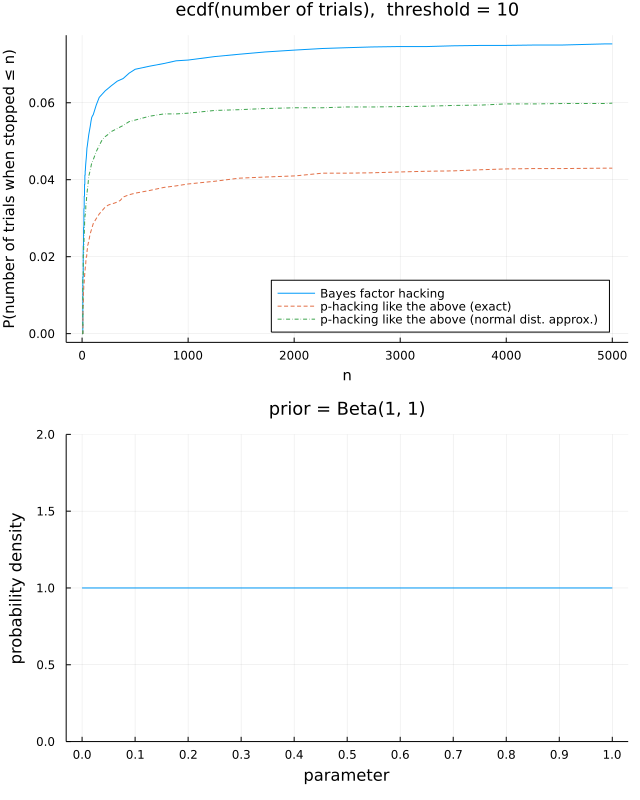

In [21]:
plot_bfhacking(; N=5000, p=0.5, threshold=10, a=1, b=1)

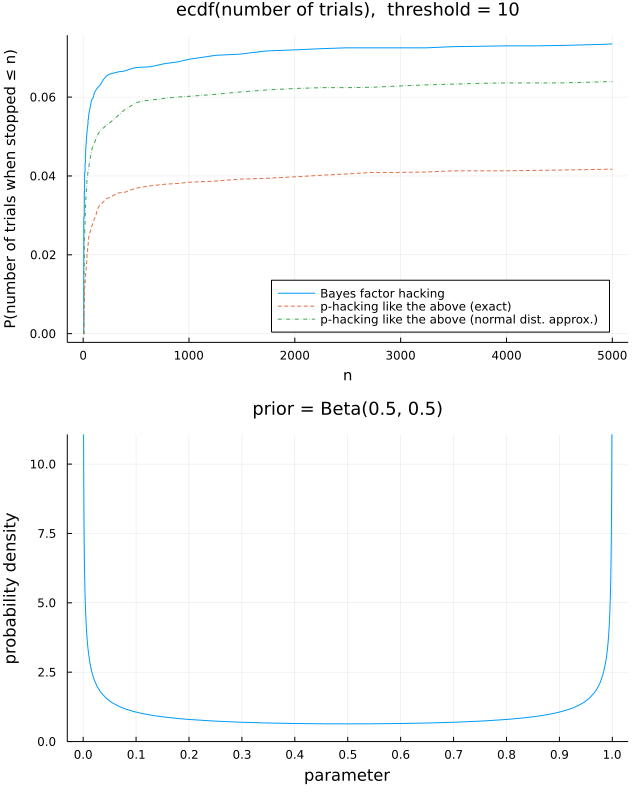

In [22]:
plot_bfhacking(; N=5000, p=0.5, threshold=10, a=0.5, b=0.5)

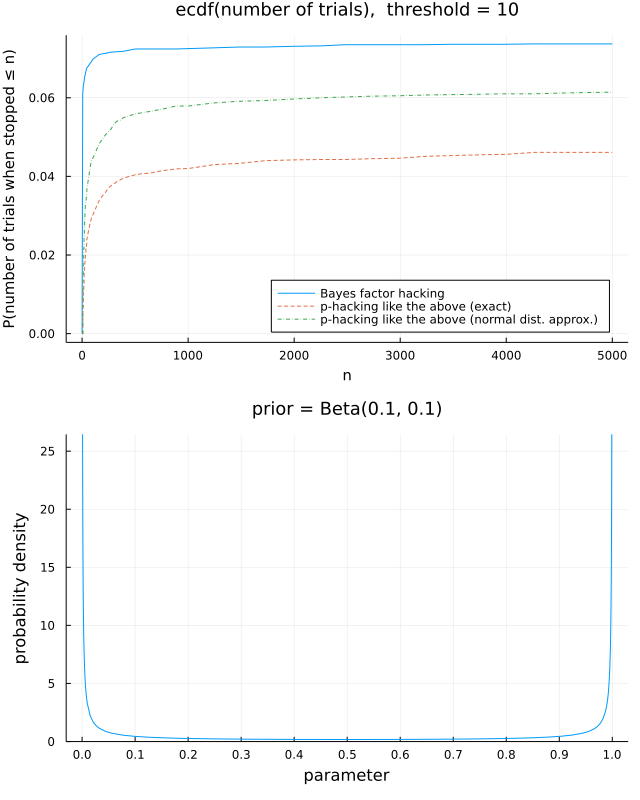

In [23]:
plot_bfhacking(; N=5000, p=0.5, threshold=10, a=0.1, b=0.1)

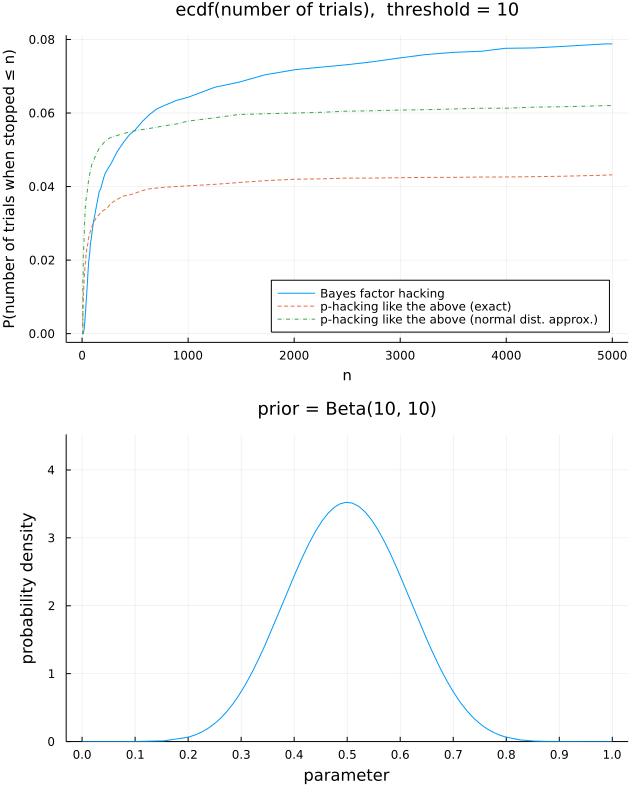

In [24]:
plot_bfhacking(; N=5000, p=0.5, threshold=10, a=10, b=10)

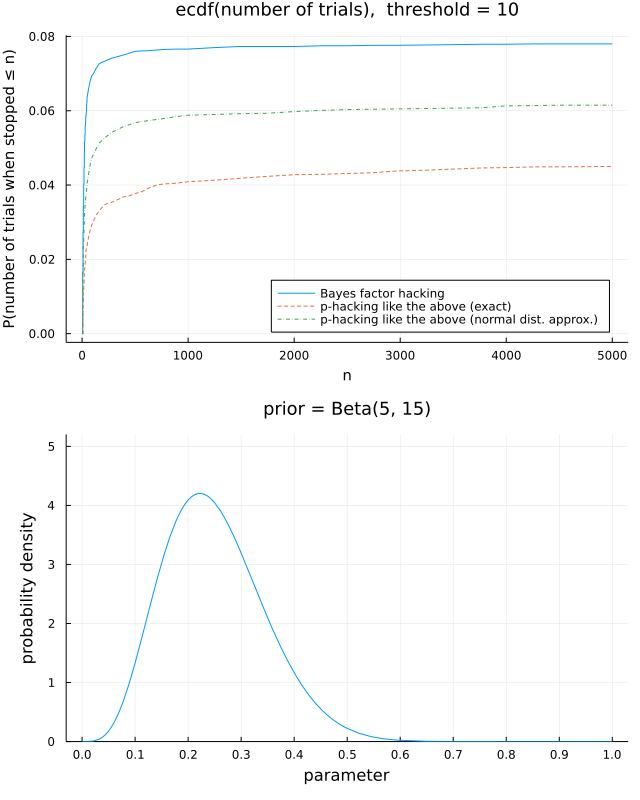

In [25]:
plot_bfhacking(; N=5000, p=0.5, threshold=10, a=5, b=15)